## Understanding Spark Query execution plans
Reference : https://www.youtube.com/watch?v=KnUXztKueMU&list=PLWAuYt0wgRcLCtWzUxNg4BjnYlCZNEVth

In [1]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("understanding_query_plans").getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/09 17:17:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Reading transaction file

trans_df = spark.read.parquet("./data/transactions.parquet")

In [6]:
trans_df.show(10)

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+------------+
|   cust_id|start_date|  end_date|         txn_id|      date|year|month|day| expense_type|   amt|        city|
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+------------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|   10|  7|Entertainment| 10.42|      boston|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|    3| 27| Motor/Travel| 44.34|    portland|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TETSXIK4BLXHJ6W|2011-04-11|2011|    4| 11|Entertainment|  3.18|     chicago|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TQKL1QFJY3EM8LO|2018-02-22|2018|    2| 22|    Groceries|268.97| los_angeles|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYL6DFP09PPXMVB|2010-10-16|2010|   10| 16|Entertainment|  2.66|     chicago|
|C0YDPQWPBJ|2010-07-01|2018-12-01|T1SMX9EUG21BBSE|2015-02-11|2015|    2| 11|    Education| 54.14|    portland|
|

In [7]:
cust_df = spark.read.parquet("./data/customers.parquet")

In [8]:
cust_df.show(10)

+----------+-------------+---+------+----------+-----+------------+
|   cust_id|         name|age|gender|  birthday|  zip|        city|
+----------+-------------+---+------+----------+-----+------------+
|C007YEYTX9| Aaron Abbott| 34|Female| 7/13/1991|97823|      boston|
|C00B971T1J| Aaron Austin| 37|Female|12/16/2004|30332|     chicago|
|C00WRSJF1Q| Aaron Barnes| 29|Female| 3/11/1977|23451|      denver|
|C01AZWQMF3|Aaron Barrett| 31|  Male|  7/9/1998|46613| los_angeles|
|C01BKUFRHA| Aaron Becker| 54|  Male|11/24/1979|40284|   san_diego|
|C01RGUNJV9|   Aaron Bell| 24|Female| 8/16/1968|86331|      denver|
|C01USDV4EE|  Aaron Blair| 35|Female|  9/9/1974|80078|    new_york|
|C01WMZQ7PN|  Aaron Brady| 51|Female| 8/20/1994|52204|philadelphia|
|C021567NJZ| Aaron Briggs| 57|  Male| 3/10/1990|22008|philadelphia|
|C023M6MKR3|  Aaron Bryan| 29|  Male| 4/10/1976|05915|philadelphia|
+----------+-------------+---+------+----------+-----+------------+
only showing top 10 rows



### Spark execution journey

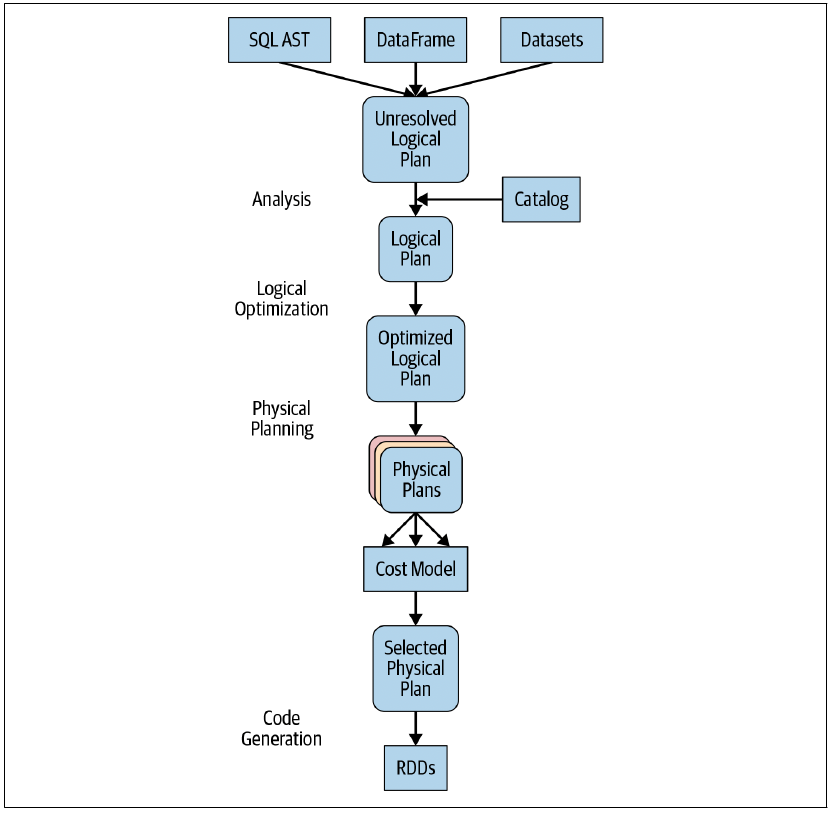

In [4]:
from IPython.display import Image
Image(filename='../UI_screenshots/query_plans/QP-1.png',width=700,height=3)

### Narrow Transformations

In [17]:
# Narrow transformations
from pyspark.sql.functions import *
trans_df_n = trans_df.where(col("expense_type") == 'Entertainment').withColumn("year",year("date")).select('cust_id','year','txn_id','expense_type','amt','city')

trans_df_n.show(10,False)
trans_df_n.explain(True)

+----------+----+---------------+-------------+-----+------------+
|cust_id   |year|txn_id         |expense_type |amt  |city        |
+----------+----+---------------+-------------+-----+------------+
|C0YDPQWPBJ|2018|TZ5SMKZY9S03OQJ|Entertainment|10.42|boston      |
|C0YDPQWPBJ|2011|TETSXIK4BLXHJ6W|Entertainment|3.18 |chicago     |
|C0YDPQWPBJ|2010|TYL6DFP09PPXMVB|Entertainment|2.66 |chicago     |
|C0YDPQWPBJ|2014|T0XX1VCPQXK0XPZ|Entertainment|2.37 |new_york    |
|C0YDPQWPBJ|2017|T1FSOGKASVCV7FM|Entertainment|4.01 |denver      |
|C0YDPQWPBJ|2016|TGO6A5NNOMI6IT5|Entertainment|2.51 |denver      |
|C0YDPQWPBJ|2018|TQ0KP2CUAB1B9IL|Entertainment|2.82 |los_angeles |
|C0YDPQWPBJ|2016|TD7BO3NK9DJ66VG|Entertainment|2.15 |boston      |
|C0YDPQWPBJ|2013|T2OR8PCD2LB0E5T|Entertainment|5.78 |philadelphia|
|C0YDPQWPBJ|2011|TFTHLMFGMW0NJ43|Entertainment|3.53 |boston      |
+----------+----+---------------+-------------+-----+------------+
only showing top 10 rows

== Parsed Logical Plan ==
'Project [

### Wide Transformations

In [19]:
# Repatition - Increase or decrease number of partitions

trans_df.rdd.getNumPartitions()

12

In [20]:
trans_df.repartition(24).explain(True)

== Parsed Logical Plan ==
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Exchange RoundRobinPartitioning(24), REPARTITION_BY_NUM, [plan_id=158]
   +- FileScan parquet [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] Batched: true, DataFilters: [], Format: Parquet, Locati

- Exchange = shuffle
- RoundRobin = partitioning strategy

In [21]:
# Coalesce - Decrease number of partitions

trans_df.rdd.getNumPartitions()

12

In [22]:
trans_df.coalesce(1).explain(True)

== Parsed Logical Plan ==
Repartition 1, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string
Repartition 1, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Repartition 1, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
Coalesce 1
+- *(1) ColumnarToRow
   +- FileScan parquet [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/Users/saitejadevalla/Desktop/SaiTeja/Git

Coalesce - doesn't show partitioning scheme. 
- Only minimizes data movement by merging into fewer partitions. Doesn't shuffle
- Since no shuffle, spark doesn't explicitly mention in plan

In [23]:
# Joins

spark.conf.set("spark.sql.autoBroadcastJoinThreshold",-1)

In [24]:
join_df = trans_df.join(cust_df, how = 'inner', on = 'cust_id')

In [25]:
join_df.explain(True)

== Parsed Logical Plan ==
'Join UsingJoin(Inner, [cust_id])
:- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet
+- Relation [cust_id#68,name#69,age#70,gender#71,birthday#72,zip#73,city#74] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string
Project [cust_id#0, start_date#1, end_date#2, txn_id#3, date#4, year#5, month#6, day#7, expense_type#8, amt#9, city#10, name#69, age#70, gender#71, birthday#72, zip#73, city#74]
+- Join Inner, (cust_id#0 = cust_id#68)
   :- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet
   +- Relation [cust_id#68,name#69,age#70,gender#71,birthday#72,zip#73,city#74] parquet

== Optimi

In [26]:
# Group by

trans_df.printSchema()

root
 |-- cust_id: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- txn_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- expense_type: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- city: string (nullable = true)



In [27]:
city_counts_df = trans_df.groupBy('city').count()

In [28]:
city_counts_df.explain(True)

== Parsed Logical Plan ==
'Aggregate ['city], ['city, count(1) AS count#236L]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
city: string, count: bigint
Aggregate [city#10], [city#10, count(1) AS count#236L]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Aggregate [city#10], [city#10, count(1) AS count#236L]
+- Project [city#10]
   +- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[city#10], functions=[count(1)], output=[city#10, count#236L])
   +- Exchange hashpartitioning(city#10, 200), ENSURE_REQUIREMENTS, [plan_id=217]
      +- HashAggregate(keys=[city#10], functions=[partial_count(1)], output=[city#10, count#240L])
         +- 

- Aggregation first happens on local level - partial count
- Exchange hashpartitioning - shuffle
- Hash aggregate - final aggregate of local counts

In [29]:
txn_amt_city_df = trans_df.groupBy('city').agg(sum('amt').alias('txn_amt'))

txn_amt_city_df.explain(True)

== Parsed Logical Plan ==
'Aggregate ['city], ['city, sum('amt) AS txn_amt#253]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
city: string, txn_amt: double
Aggregate [city#10], [city#10, sum(cast(amt#9 as double)) AS txn_amt#253]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Aggregate [city#10], [city#10, sum(cast(amt#9 as double)) AS txn_amt#253]
+- Project [amt#9, city#10]
   +- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[city#10], functions=[sum(cast(amt#9 as double))], output=[city#10, txn_amt#253])
   +- Exchange hashpartitioning(city#10, 200), ENSURE_REQUIREMENTS, [plan_id=230]
      +- HashAggregate(keys=[city#10], func

In [30]:
# Group by distinct

txn_per_city_df = trans_df.groupBy('cust_id').agg(countDistinct('city').alias('city_count'))
txn_per_city_df.show(10)
txn_per_city_df.explain(True)

+----------+----------+
|   cust_id|city_count|
+----------+----------+
|CPP8BY8U93|        10|
|CYB8BX9LU1|        10|
|CFRT841CCD|        10|
|CA0TSNMYDK|        10|
|COZ8NONEVZ|        10|
|C46OCVH3WG|        10|
|C1QF29WCA6|        10|
|CTJBQB0OJ1|        10|
|CD0DXL8XTM|        10|
|CADBQ5OL5C|        10|
+----------+----------+
only showing top 10 rows

== Parsed Logical Plan ==
'Aggregate ['cust_id], ['cust_id, 'count(distinct 'city) AS city_count#269]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, city_count: bigint
Aggregate [cust_id#0], [cust_id#0, count(distinct city#10) AS city_count#269L]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Aggregate [cust_id#0], [cust_id#0, count(distinct city#10) AS city_count#269L]
+- Project [cust_id#0, city#10]
   +- R

In [32]:
# Predicate pushdown doesn't work everytime

cust_df_50 = cust_df.where(col('age').cast('int')>50)
cust_df_50.show(10,False)
cust_df_50.explain(True)

+----------+--------------+---+------+----------+-----+------------+
|cust_id   |name          |age|gender|birthday  |zip  |city        |
+----------+--------------+---+------+----------+-----+------------+
|C01BKUFRHA|Aaron Becker  |54 |Male  |11/24/1979|40284|san_diego   |
|C01WMZQ7PN|Aaron Brady   |51 |Female|8/20/1994 |52204|philadelphia|
|C021567NJZ|Aaron Briggs  |57 |Male  |3/10/1990 |22008|philadelphia|
|C02JNTM46B|Aaron Chambers|51 |Male  |1/6/2001  |63337|new_york    |
|C030A69V1L|Aaron Clarke  |55 |Male  |4/28/1999 |77176|philadelphia|
|C034RB2MQ6|Aaron Ford    |63 |Male  |7/8/1988  |90592|chicago     |
|C03U340T3R|Aaron Gardner |59 |Female|3/18/1975 |31502|denver      |
|C044XUK8IK|Aaron Gibbs   |58 |Male  |5/17/1999 |67547|seattle     |
|C0694GX5HW|Aaron Guerrero|62 |Male  |8/17/1976 |39243|denver      |
|C07OSZNHI9|Aaron Harper  |65 |Female|3/29/2004 |27672|seattle     |
+----------+--------------+---+------+----------+-----+------------+
only showing top 10 rows

== Parse

Predicate pushdown didn't worked because of cast operation

In [33]:
spark.stop()